# Fitting

## B-spline基底関数
節点を等間隔に配置した場合 ($0, h, 2h, 3h, \ldots$ )
+ 1次のB-spline
$b_{1,0}(z)=0\quad (z < 0, z \geq 2h)$  
$b_{1,0}(z)=z/h \quad (0\leq z < h)$  
$b_{1,0}(z)=2-z/h \quad (h\leq z < 2h)$.  

+ 2次のB-spline
$b_{2,0}(z)=0\quad (z < 0, z \geq 3h)$  
$\displaystyle b_{2,0}(z)=\frac{z^2}{2h^2} \quad (0\leq z < h)$  
$\displaystyle b_{2,0}(z)=-\frac{z^2}{h^2}+\frac{3z}{h}-\frac{3}{2} (h\leq z < 2h)$  
$\displaystyle b_{2,0}(z)=\frac{(3h-z)^2}{2h^2} (2h\leq z < 3h)$  

+ 3次のB-spline
$b_{3,0}(z)=0\quad (z < 0, z \geq 4h)$  
$\displaystyle b_{3,0}(z)=\frac{z^3}{2h^3} \quad (0\leq z < h)$  
$\displaystyle b_{3,0}(z)=-\frac{z^3}{2h^3}+\frac{2z^2}{h^2}-\frac{2z}{h}-\frac{2}{3} (h\leq z < 2h)$  
$\displaystyle b_{3,0}(z)=\frac{z^3}{2h^3}-\frac{4z^2}{h^2}+\frac{10z}{h}-\frac{22}{3} (2h\leq z < 3h)$  
$\displaystyle b_{3,0}(z)=\frac{(4h-z)^3}{6h^3} (3h\leq z < 4h)$  

In [55]:
import numpy as np
import matplotlib.pylab as plt

# 3rd order B-spline
def bspline3( t, t0, scale ):
  tshift = (t - t0) / scale + 2.0

  if tshift < 0:
    a = 0
  elif tshift < 1:
    a = tshift**3 / 6.0
  elif tshift < 2:
    a = -0.5*tshift**3 + 2.0*tshift**2 - 2.0*tshift + 2.0/3.0
  elif tshift < 3:
    a = 0.5*tshift**3 - 4.0*tshift**2 + 10.0*tshift - 22.0/3.0
  elif tshift < 4:
    a = (4 - tshift)**3 / 6.0
  else:
    a = 0.0

  return a

In [70]:
zintvl = 3.0/12.0
znode = 1981.0 + np.arange( -zintvl, 30.0 + 2.0*zintvl, zintvl )

data = np.loadtxt("ssn.dat")
#data = np.loadtxt("ssn2.dat")

y = data[:,2]
zobs = data[:,0] + (data[:,1]-0.5)/12.0

n = len(y)
m = len(znode)
print("dim x:", m,", dim y:", n)

# Observation matrix
Hmat = np.zeros(( n, m ))
for i in range(n):
  for j in range(m):
    Hmat[i,j] = bspline3( zobs[i], znode[j], zintvl )

dim x: 123 , dim y: 360


## 特異値分解
実行列$\mathsf{H}$は，$\mathsf{H}=\mathsf{U}\mathsf{S}\mathsf{V}^T$の形に分解できる．
但し，$\mathsf{U}$, $\mathsf{V}$は正規直交行列，$\mathsf{S}$は対角行列．

$\dim \boldsymbol{y} >\dim\boldsymbol{x}$のとき，$\|\boldsymbol{y}-\mathsf{H}\boldsymbol{x}\|^2$を最小にする$\boldsymbol{x}$は，
$\boldsymbol{x}_{\mathrm{est}}=\mathsf{V}\mathsf{S}^{-1}\mathsf{U}^T\boldsymbol{y}$.

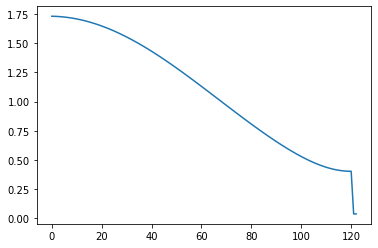

In [71]:
eps = 0.01

U, s, Vt = np.linalg.svd( Hmat )

plt.plot(s)
plt.show()

for i in range(1, m):
  if s[i] < eps*s[0]:
    s[i] = 0.0
  else:
    s[i] = 1.0/s[i]

s[0] = 1.0/s[0]


Sinv = np.diag( s )
HinvT = U[:,0:m].dot(Sinv.dot(Vt))

xest = HinvT.T.dot(y)
yest = Hmat.dot(xest)

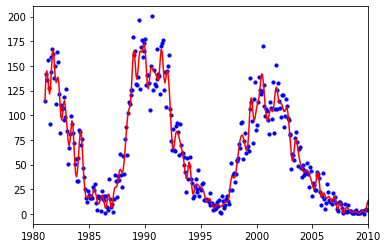

In [72]:
plt.scatter(zobs, y, color='b', s=10)
plt.plot(zobs, yest, color='r')
plt.xlim(1980, 2010)
plt.show()

## ベイズ推定
  $p(\boldsymbol{x})\propto\exp\left[-\frac{1}{2}\boldsymbol{x}^T\mathsf{P}_b^{-1}\boldsymbol{x}\right]$,  
  $p(\boldsymbol{y}|\boldsymbol{x})\propto\exp\left[-\frac{1}{2}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})^T\mathsf{R}^{-1}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})\right]$  
として，事後分布$p(\boldsymbol{x}|\boldsymbol{y})$を最大化する$\boldsymbol{x}$を求める．

事後分布は  
  $p(\boldsymbol{x}|\boldsymbol{y})\propto\exp\left[-\frac{1}{2}(\boldsymbol{x}-\hat{\boldsymbol{x}})^T\hat{\mathsf{P}}^{-1}(\boldsymbol{x}-\hat{\boldsymbol{x}})\right]$,  
但し，  
  $\hat{\boldsymbol{x}}=\mathsf{P}_{b}\mathsf{H}(\mathsf{H}\mathsf{P}_{b}\mathsf{H}^T+\mathsf{R})^{-1}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})=(\mathsf{P}_{b}^{-1}+\mathsf{H}^T\mathsf{R}^{-1}\mathsf{H})^{-1}\mathsf{H}^T\mathsf{R}^{-1}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})$,  
  $\hat{\mathsf{P}}=\mathsf{P}_{b}-\mathsf{P}_{b}\mathsf{H}(\mathsf{H}\mathsf{P}_{b}\mathsf{H}^T+\mathsf{R})^{-1}\mathsf{H}\mathsf{P}_b$.
  
## 周辺尤度
$\mathsf{P}_b$, $\mathsf{R}$を調整するパラメータは，周辺尤度  
  $\displaystyle p(\boldsymbol{y}|\boldsymbol{\theta} )=\int p(\boldsymbol{y}|\boldsymbol{x}, \boldsymbol{\theta} )\,p(\boldsymbol{x}|\boldsymbol{\theta} )\,d\boldsymbol{x}$  
が大きくなるように選ぶのが一つの手段となる．但し，$\boldsymbol{\theta}$はパラメータをまとめたベクトルである．  
  $\displaystyle p(\boldsymbol{x}|\boldsymbol{\theta})=\frac{1}{\sqrt{(2\pi )^m\left|\mathsf{P_b}\right|}}\exp\left[-\frac{1}{2}\boldsymbol{x}^T\mathsf{P}_b^{-1}\boldsymbol{x}\right]$,  
  $\displaystyle p(\boldsymbol{y}|\boldsymbol{x},\boldsymbol{\theta})=\frac{1}{\sqrt{(2\pi )^n\left|\mathsf{R}\right|}} \exp\left[-\frac{1}{2}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})^T\mathsf{R}^{-1}(\boldsymbol{y}-\mathsf{H}\boldsymbol{x})\right]$  
とすると，周辺尤度は  
  $\displaystyle p(\boldsymbol{y}|\boldsymbol{\theta} )=\frac{1}{\sqrt{(2\pi )^n\left|\mathsf{H}\mathsf{P}_b\mathsf{H}^T+\mathsf{R}\right|}}\exp\left[-\frac{1}{2}\boldsymbol{y}^T(\mathsf{H}\mathsf{P}_b\mathsf{H}^T+\mathsf{R})^{-1}\boldsymbol{y}\right]$.  

In [96]:
# Inverse of prior covariance
eta = 1.0e-6
Pinvsm = np.zeros(( m, m ))
for i in range(1,m-1):
  Pinvsm[i,i] += eta
  Pinvsm[i,i] += 1.0
  Pinvsm[i+1,i+1] += 0.25
  Pinvsm[i+1,i-1] += 0.25
  Pinvsm[i-1,i+1] += 0.25
  Pinvsm[i-1,i-1] += 0.25
  Pinvsm[i,i-1] -= 0.5
  Pinvsm[i-1,i] -= 0.5
  Pinvsm[i,i+1] -= 0.5
  Pinvsm[i+1,i] -= 0.5

Pinvsm[0,0] += eta
Pinvsm[m-1,m-1] += eta

Pinv = np.eye(m)
#Pinv = Pinvsm

In [104]:
xi = 30.0
rsig = 10.0

HHmat = Hmat.T.dot(Hmat)/(rsig*rsig) + Pinv/(xi*xi)
Ppost = np.linalg.inv(HHmat)
Hy = Hmat.T.dot(y)/(rsig*rsig)
xest = Ppost.dot(Hy)
yest = Hmat.dot(xest)

#vv = Hmat.dot(Ppost.dot(Hmat.T))+rsig*rsig*np.eye(n)
#sigarr = np.zeros((n))
#for i in range(n):
#  sigarr[i] = 2.0*np.sqrt(vv[i,i])

xll = -0.5*y.dot(y-yest)/(rsig*rsig)
xll -= 0.5 * (np.log(np.linalg.det(HHmat)) + m*np.log(2.0*np.pi))
xll += 0.5 * (np.log(np.linalg.det(Pinv)) - 2*m*np.log(xi) - 2*n*np.log(rsig))

print("L={0:10.3f}".format(xll))

L= -1753.917


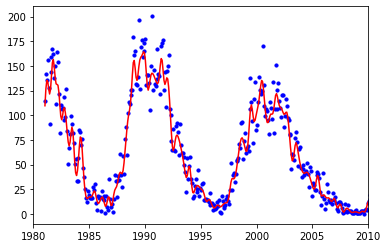

In [105]:
plt.scatter(zobs, y, color='b', s=10)
plt.plot(zobs, yest, color='r')
plt.xlim(1980, 2010)
plt.show()